# Explore data

This is an exploratory notebook, it is not meant to go to customer.

In [1]:
import numpy as np
import numpy.random as npr
import scipy as sp
import scipy.stats as sp_st
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm

import duckdb as ddb

import catboost as cb
import json
import typing as tp

import sklearn.metrics as sk_mx
import sklearn.linear_model as sk_lm

Lets explore column by column

In [2]:
con = ddb.connect()

# Load the Parquet file into DuckDB
con.execute(f"CREATE TABLE txns AS SELECT * FROM 'train_txns.parquet'")
con.execute(f"CREATE TABLE labels AS SELECT * FROM 'labels.parquet'")
con.execute(
    f"""
    CREATE TABLE ext_txns AS (
        SELECT
            T.eventId,
            T.transactionTime,
            YEAR(T.transactionTime) AS txn_year,
            MONTH(T.transactionTime) AS txn_month,
            DAYOFMONTH(T.transactionTime) AS txn_day_of_month,
            DAYOFWEEK(T.transactionTime) AS txn_day_of_week,
            HOUR(T.transactionTime) AS txn_hour,
            MINUTE(T.transactionTime) AS txn_minute,
            SECOND(T.transactionTime) AS txn_second,
            T.accountNumber,
            T.merchantId,
            T.mcc,
            T.merchantCountry,
            T.merchantZip,
            T.posEntryMode,
            T.transactionAmount,
            T.availableCash,
            L.reportedTime,
        FROM txns AS T
        LEFT JOIN labels AS L
            ON L.eventId=T.eventId
    )"""
)

sample_df = con.execute(
    f"""
    SELECT * FROM ext_txns WHERE RANDOM()<0.05 LIMIT 10
    """
).df()

sample_df

# con.close()


,eventId,transactionTime,txn_year,txn_month,txn_day_of_month,txn_day_of_week,txn_hour,txn_minute,txn_second,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime
0,33390172A1,2017-01-20 15:25:03,2017,1,20,5,15,25,3,37eedc90,a13c8b,6011,826,0,5,11.00,500.0,NaT
1,71143138A1,2017-01-27 05:17:16,2017,1,27,5,5,17,16,900dffd5,397e4b,7399,826,SW1W,81,0.00,4500.0,NaT
2,2995981A1,2017-06-26 13:18:59,2017,6,26,1,13,18,59,7158941b,1ab538,5542,826,AB22,5,2.00,1500.0,NaT
3,29633658A1,2017-06-27 20:48:07,2017,6,27,2,20,48,7,2f6ef594,f263bf,5411,826,NW4,5,25.04,7500.0,NaT
4,65644284A1,2017-07-24 06:40:54,2017,7,24,1,6,40,54,b8796d10,96878e,5942,442,None,81,40.14,2500.0,NaT
5,62290757A1,2018-01-26 08:24:22,2018,1,26,5,8,24,22,4b11714c,ab7527,7321,826,0,1,9.98,3500.0,NaT
6,4911135A1,2017-12-03 15:44:21,2017,12,3,0,15,44,21,82ad64e3,356736,7230,826,SO53,5,25.00,10500.0,NaT
7,94564835A1,2017-05-27 14:59:54,2017,5,27,6,14,59,54,7a166e60,9f0512,5813,826,CH5,5,40.34,8500.0,NaT
8,77979379A1,2017-03-02 12:57:40,2017,3,2,4,12,57,40,2e6bbec5,0d6c8c,7832,826,TD1,5,25.00,7500.0,NaT
9,58132330A1,2017-08-20 01:54:08,2017,8,20,0,1,54,8,46c36895,c13dda,5812,826,W1F,5,117.70,8500.0,NaT


## Time-lag between transaction and report


In [3]:
diff_df = con.execute(
    f"""
    SELECT
        *,
        DATEDIFF('HOUR', min_txn_time, transactionTime) AS hours_since_min,
        DATEDIFF('MONTH', transactionTime, reportedTime) AS difference_moths,
        DATEDIFF('DAY', transactionTime, reportedTime) AS difference_days,
        DATEDIFF('HOUR', transactionTime, reportedTime) AS difference_hours,
        DATEDIFF('MINUTE', transactionTime, reportedTime) AS difference_minutes
    FROM ext_txns AS E
    CROSS JOIN (SELECT MIN(transactionTime) AS min_txn_time FROM ext_txns) AS M
    WHERE reportedTime IS NOT NULL
    """
).df().sort_values('hours_since_min')

print(f'Got {len(diff_df)} records')
print(f'Got {np.sum(diff_df.difference_hours<0)} invalid time delay records')
diff_df.head(5)

Got 628 records
Got 0 invalid time delay records


,eventId,transactionTime,txn_year,txn_month,txn_day_of_month,txn_day_of_week,txn_hour,txn_minute,txn_second,accountNumber,...,posEntryMode,transactionAmount,availableCash,reportedTime,min_txn_time,hours_since_min,difference_moths,difference_days,difference_hours,difference_minutes
325,85602730A1,2017-01-01 03:53:34,2017,1,1,0,3,53,34,645c318d,...,5,10.95,1500.0,2017-01-14,2017-01-01,3,0,13,309,18487
319,101536473A1,2017-01-03 13:43:45,2017,1,3,2,13,43,45,f42ba1f1,...,1,1.36,1500.0,2017-01-04,2017-01-01,61,0,1,11,617
278,101536857A1,2017-01-03 13:27:22,2017,1,3,2,13,27,22,f42ba1f1,...,1,11.00,1500.0,2017-01-04,2017-01-01,61,0,1,11,633
335,101536905A1,2017-01-03 13:37:54,2017,1,3,2,13,37,54,f42ba1f1,...,1,0.74,1500.0,2017-01-04,2017-01-01,61,0,1,11,623
53,101536329A1,2017-01-03 13:27:02,2017,1,3,2,13,27,2,f42ba1f1,...,1,9.00,1500.0,2017-01-04,2017-01-01,61,0,1,11,633


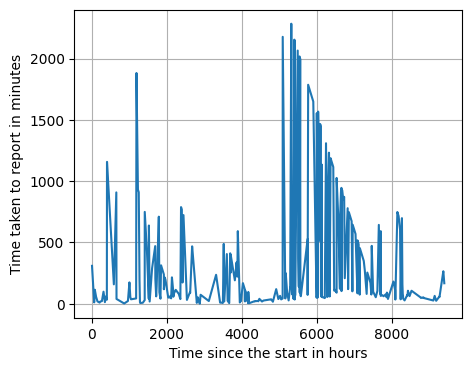

In [4]:
fig, ax = pp.subplots(figsize=(5, 4))
ax.plot(diff_df.hours_since_min, diff_df.difference_hours)
ax.set_xlabel('Time since the start in hours')
ax.set_ylabel('Time taken to report in minutes')
ax.grid()

Some transactions take a long time to be declared as fraudulent. Is this important?

**Question:** Is the lag between transaction and report time important. Are all reported transactions equally important to detect?  

## Periodicity

Is there preference towards certain times amongst normal and fraudulent transactions?

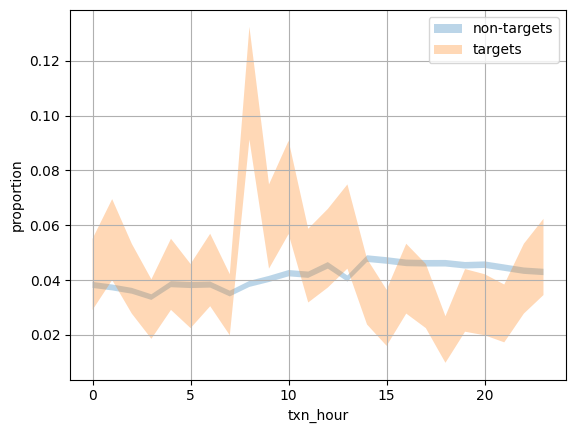

In [5]:
target_periodic_feature_name = 'txn_hour'

####
non_target_arr = con.execute(
    f"""
    SELECT {target_periodic_feature_name} FROM ext_txns WHERE reportedTime IS NULL
    """
).df()[target_periodic_feature_name].values
####
target_arr = con.execute(
    f"""
    SELECT {target_periodic_feature_name} FROM ext_txns WHERE reportedTime IS NOT NULL
    """
).df()[target_periodic_feature_name].values
####

common_bins = np.arange(0, np.max([np.max(non_target_arr), np.max(target_arr)])+2)-0.5
common_mids = (common_bins[:-1]+common_bins[1:])/2

fig, ax = pp.subplots()
non_target_counts, _ = np.histogram(non_target_arr, bins = common_bins)
target_counts, _ = np.histogram(target_arr, bins = common_bins)
#
ax.fill_between(
    x=common_mids,
    y1=sp_st.beta(non_target_counts+1, np.sum(non_target_counts)-non_target_counts+1).ppf(0.05), 
    y2=sp_st.beta(non_target_counts+1, np.sum(non_target_counts)-non_target_counts+1).ppf(0.95), 
    label='non-targets',
    alpha=0.3
)
#
ax.fill_between(
    x=common_mids,
    y1=sp_st.beta(target_counts+1, np.sum(target_counts)-target_counts+1).ppf(0.05), 
    y2=sp_st.beta(target_counts+1, np.sum(target_counts)-target_counts+1).ppf(0.95), 
    label='targets',
    alpha=0.3
)
#
ax.legend()
ax.set_xlabel(target_periodic_feature_name)
ax.set_ylabel('proportion')
ax.grid()

Observations. 

* There seem to be more targets in the summer
* A lot more targets around 20th of the month
* More targets 1st day of the week
* More targets around 9am on the day

  

**Question:** There seem to be quite strong periodic patterns - targets tend to occur with certain periodicity. How much error is there in the transaction time?  
**Question:** Are merchants with fraudulent transactions expected to be exited?

## Categorical features

For most of these we want to know the:
* cardinality
* how often it repeats
* how much of it is missing

In [6]:
name_of_categorical_feature = 'merchantZip'

missing_df = con.execute(
    f"""
    SELECT
        COUNT(*) AS row_count,
        COUNT_IF({name_of_categorical_feature} IS NULL) AS missing_count
    FROM ext_txns
    """
).df()

full_count = missing_df.row_count.iloc[0]
missing_count = missing_df.missing_count.iloc[0]

print(f'{name_of_categorical_feature}: {missing_count} out of {full_count} is missing ({missing_count/full_count*100:.3f})%')

merchantZip: 16134.0 out of 83035 is missing (19.430)%


Missingness:
* `accountNumber`: 0 out of 83,035
* `merchantId`: 0 out of 83,035
* `mcc`: 0 out of 83,035
* `merchantCountry`: 0 out of 83,035
* `merchantZip`: 16198 out of 83035 is missing (19.507)%
* `posEntryMode`: 0 out of 83,035

So only the merchant zip can be missing

**Question:** `merchantZip` is missing in substantial number of records. It can be missing either as not present, or it can be simply `0`. Are both of these to be treated the same way or is there a conceptual difference?

Next, how many reps do we get per individual value

posEntryMode: number of distinct categories 10


,posEntryMode,distinct_per_cat_count,per_cat_count
2,5,49191,49191
0,81,25038,25038
5,1,7401,7401
1,90,849,849
7,7,450,450
9,80,60,60
6,79,26,26
8,2,11,11
3,0,8,8
4,91,1,1


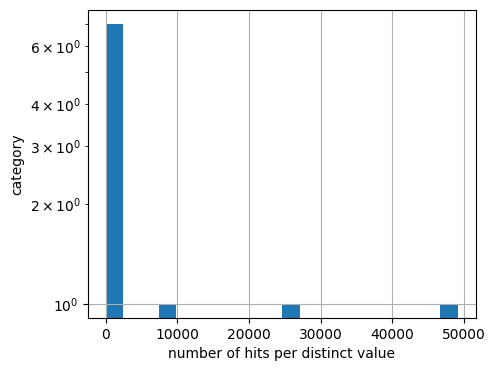

In [7]:
name_of_categorical_feature = 'posEntryMode'

agg_df = con.execute(
    f"""
    SELECT
        {name_of_categorical_feature},
        COUNT(DISTINCT eventId) AS distinct_per_cat_count,
        COUNT(*) AS per_cat_count,
    FROM ext_txns
    GROUP BY {name_of_categorical_feature}
    """
).df().sort_values('per_cat_count', ascending=False)

print(f'{name_of_categorical_feature}: number of distinct categories {agg_df[name_of_categorical_feature].nunique()}')

fig, ax = pp.subplots(figsize=(5, 4))
ax.hist(agg_df.distinct_per_cat_count, bins=20)
ax.set_xlabel('number of hits per distinct value')
ax.set_ylabel('category')
ax.grid()
ax.set_yscale('log')

agg_df.head(10)

* `accountNumber`: power law in distribution. 764 accounts, with nearly 100 transactions on the highest one
* `merchantId`: power law in distribution. 26,621 merchants most have few transactions, but highest ones have 1k+. long tail
* `mcc`: merchant category code. similar 348 merchants, with 16,648 per highest category
* `merchantCountry`: 80 countries, with a half or so in one country, then 6x less in another, 5x less in another and so on
* `merchantZip`: 2992 zips, including the missing. Biggest category is missing, second biggest is `0` which is also missing, probably, then it is few hundred per value
* `posEntryMode`: 10 options, mostly split between 5 (POS Entry Circuit Card), 81 (POS Entry E-Commerce) and 1 (Entry Mode Unknown)

Association with the risk

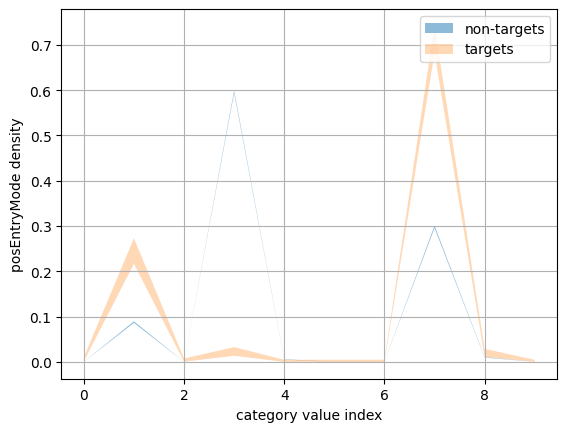

In [8]:
name_of_categorical_feature = 'posEntryMode'

risk_df = con.execute(
    f"""
    SELECT
        {name_of_categorical_feature},
        COUNT(DISTINCT eventId) AS distinct_per_cat_count,
        COUNT(DISTINCT CASE WHEN reportedTime IS NULL THEN eventId ELSE NULL END) AS non_target_count,
        COUNT(DISTINCT CASE WHEN reportedTime IS NOT NULL THEN eventId ELSE NULL END) AS target_count,
    FROM ext_txns
    GROUP BY {name_of_categorical_feature}
    """
).df().sort_values(name_of_categorical_feature)


#####

common_bins = np.arange(0, len(risk_df)+1)-0.5
common_mids = (common_bins[:-1]+common_bins[1:])/2

fig, ax = pp.subplots()
non_target_counts = risk_df.non_target_count.values
target_counts = risk_df.target_count.values
#
ax.fill_between(
    x=common_mids,
    y1=sp_st.beta(non_target_counts+1, np.sum(non_target_counts)-non_target_counts+1).ppf(0.05), 
    y2=sp_st.beta(non_target_counts+1, np.sum(non_target_counts)-non_target_counts+1).ppf(0.95), 
    label='non-targets',
    alpha=0.5
)

ax.fill_between(
    x=common_mids,
    y1=sp_st.beta(target_counts+1, np.sum(target_counts)-target_counts+1).ppf(0.05), 
    y2=sp_st.beta(target_counts+1, np.sum(target_counts)-target_counts+1).ppf(0.95), 
    label='targets',
    alpha=0.3
)

ax.legend()
ax.set_xlabel('category value index')
ax.set_ylabel(f'{name_of_categorical_feature} density')
ax.grid()

Difference in target non-target distribution:
* `posEntryMode`
* `availableCash` - which due to being rounded actually behaves more like a categorical feature

Not much difference with anything else

## Continuous features

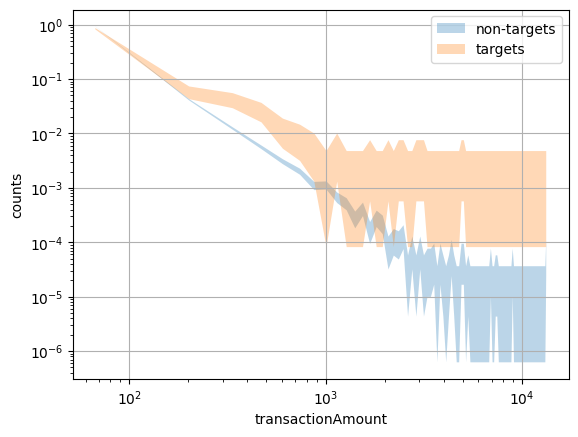

In [9]:
cont_feature_name = 'transactionAmount'

############
non_target_arr = con.execute(
    f"""
    SELECT
        {cont_feature_name},
    FROM ext_txns
    WHERE reportedTime IS NULL
    """
).df()[cont_feature_name].values
############
target_arr = con.execute(
    f"""
    SELECT
        {cont_feature_name},
    FROM ext_txns
    WHERE reportedTime IS NOT NULL
    """
).df()[cont_feature_name].values

eps = 1e-6
common_bins = np.linspace(
    np.min([*non_target_arr, *target_arr])-eps,
    np.max([*non_target_arr, *target_arr])+eps,
    100
)
#
common_mids = (common_bins[1:]+common_bins[:-1])/2

non_target_counts, _ = np.histogram(non_target_arr, bins=common_bins)
target_counts, _ = np.histogram(target_arr, bins=common_bins)

fig, ax = pp.subplots()

ax.fill_between(
    x=common_mids,
    y1=sp_st.beta(non_target_counts+1, np.sum(non_target_counts)-non_target_counts+1).ppf(0.05), 
    y2=sp_st.beta(non_target_counts+1, np.sum(non_target_counts)-non_target_counts+1).ppf(0.95), 
    label='non-targets',
    alpha=0.3
)
#
ax.fill_between(
    x=common_mids,
    y1=sp_st.beta(target_counts+1, np.sum(target_counts)-target_counts+1).ppf(0.05), 
    y2=sp_st.beta(target_counts+1, np.sum(target_counts)-target_counts+1).ppf(0.95), 
    label='targets',
    alpha=0.3
)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(cont_feature_name)
ax.set_ylabel('counts')
ax.legend()
ax.grid()

Targets seem to have a slight distribution bump around few hudred in `transactionAmount`.

**Question:** Are there any hard rules expected around transactions that far exceed the available amounts?

## Classifier

I think we are ready to move to the classifier. Bear in mind that:
```
They plan to have a small team of fraud analysts who review risky-looking purchases and decide whether to allow or block the transaction. This team will have the capacity to review 400 transactions a month. The scores from your model will be used to decide which transactions the fraud analysts should review. The bank is requesting that after working these alerts, as much fraud value as possible has been prevented. 
```

So the objective is to minimize the amount of money lost, and the capacity is to investigate 400 transactions per month. What is our baseline? How much loss would there be if we were to investigate no cases? How much if we chacked random 400 cases?

In [10]:
investigations_hash = "42fish5454~"

 # number of transactions that can be investigated, per month, by FI, taking into account that only 70% of transactions are in this set
investigative_capacity_per_month = np.round(400*0.7).astype(int)

baseline_loss_df = con.execute(
    f"""
    WITH
    investigation_flag_vw AS (
        SELECT
            *,
            ROW_NUMBER() OVER(PARTITION BY txn_year, txn_month ORDER BY HASH(CONCAT(eventId, '{investigations_hash}'))) AS investigate_selection_order
        FROM ext_txns
    )
    ,
    txn_classification_vw AS (
        SELECT
            *,
            CASE
                WHEN (investigate_selection_order<={investigative_capacity_per_month}) AND (reportedTime IS NOT NULL) THEN 'TP'
                WHEN (investigate_selection_order<={investigative_capacity_per_month}) AND (reportedTime IS NULL) THEN 'FP'
                WHEN (investigate_selection_order>{investigative_capacity_per_month}) AND (reportedTime IS NOT NULL) THEN 'FN'
                ELSE 'TN'
            END AS txn_classification
        FROM investigation_flag_vw
    )
    ,
    grouped_vw AS (
        SELECT
            txn_year,
            txn_month,
            (12*txn_year+txn_month-1) AS rel_month,
            COUNT(DISTINCT eventId) AS txn_count,
            SUM(transactionAmount) AS full_txn_amount,
            SUM(CASE WHEN reportedTime IS NOT NULL THEN transactionAmount ELSE 0 END) AS fraud_txn_amount,
            SUM(CASE WHEN txn_classification='FN' THEN transactionAmount ELSE 0 END) AS fraud_txn_amount_after_random_investigation,
            SUM(CASE WHEN reportedTime IS NOT NULL THEN 1 ELSE 0 END) AS fraud_count,
            SUM(CASE WHEN txn_classification='TP' THEN 1 ELSE 0 END) AS tp_count,
            SUM(CASE WHEN txn_classification='FP' THEN 1 ELSE 0 END) AS fp_count,
        FROM txn_classification_vw
        GROUP BY txn_year, txn_month
    )
    
    SELECT 
        G.* EXCLUDE(rel_month),
        G.rel_month - M.min_rel_month AS rel_month
    FROM grouped_vw AS G
    CROSS JOIN (SELECT MIN(rel_month) AS min_rel_month FROM grouped_vw) AS M
    ORDER BY G.rel_month
    """
).df()

baseline_loss_df

,txn_year,txn_month,txn_count,full_txn_amount,fraud_txn_amount,fraud_txn_amount_after_random_investigation,fraud_count,tp_count,fp_count,rel_month
0,2017,1,6340,359579.27,990.90,972.11,25.0,2.0,278.0,0
1,2017,2,6004,315539.76,1231.53,1205.53,26.0,1.0,279.0,1
2,2017,3,6646,354526.88,4150.67,3751.67,46.0,1.0,279.0,2
3,2017,4,6082,328845.48,2012.34,2006.46,41.0,1.0,279.0,3
4,2017,5,6558,313901.95,1341.55,1341.55,16.0,0.0,280.0,4
5,2017,6,6051,366736.78,18191.30,15041.91,111.0,6.0,274.0,5
6,2017,7,6902,346637.41,8588.35,7624.23,68.0,4.0,276.0,6
7,2017,8,7796,404177.25,7333.38,7260.89,50.0,2.0,278.0,7
8,2017,9,6371,357145.15,14536.82,14301.20,81.0,5.0,275.0,8
9,2017,10,6103,324284.63,8105.57,7823.45,79.0,3.0,277.0,9


For the key metric is money lost to fraud, given capacity to investigate 400 transactions per month. Train_test dataset is already 70% of all transactions (30% is left for eval). How many txns and how many months do we have?

In [11]:
baseline_loss_df.txn_count.mean()

6387.307692307692

And we can use 400*0.7 investigations for it, so around

In [12]:
investigations_per_txn = (400*0.7)/baseline_loss_df.txn_count.mean()
investigations_per_txn

0.04383693623170952

Per transaction. Plot the ammount of loss and the ammount of loss if a correspondingly large fraction of transactions was investigated randomly (as per capacity of FI)

No investigations loss: 74512.380
Random investigations loss: 69050.650 (-7.330%)


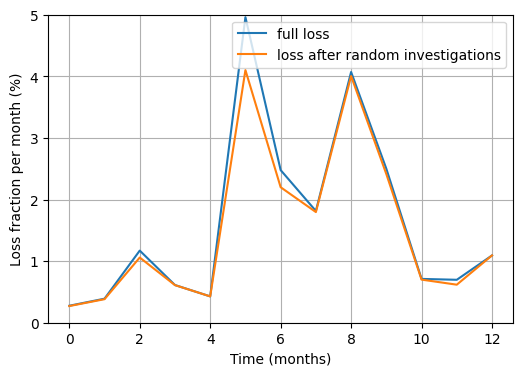

In [13]:
fig, ax = pp.subplots(figsize=(6, 4))

ax.plot(
    baseline_loss_df.rel_month, 
    (baseline_loss_df.fraud_txn_amount/baseline_loss_df.full_txn_amount)*100, 
    label='full loss'
)
#
ax.plot(
    baseline_loss_df.rel_month,
    (baseline_loss_df.fraud_txn_amount_after_random_investigation/baseline_loss_df.full_txn_amount)*100,
    label='loss after random investigations'
)
#
ax.set_xlabel('Time (months)')
ax.set_ylabel('Loss fraction per month (%)')
ax.grid()
ax.set_ylim([0, 5])
ax.legend()

####

full_fraud_ammount = baseline_loss_df.fraud_txn_amount.sum()
fraud_amount_after_investigations = baseline_loss_df.fraud_txn_amount_after_random_investigation.sum()
delta_amount = fraud_amount_after_investigations - full_fraud_ammount

print(f'No investigations loss: {full_fraud_ammount:.3f}')
print(f'Random investigations loss: {fraud_amount_after_investigations:.3f} ({delta_amount/full_fraud_ammount*100:.3f}%)')

In [14]:
np.mean(baseline_loss_df.fraud_txn_amount_after_random_investigation/baseline_loss_df.full_txn_amount)

0.01513228782618969

So loss fluctuates between 0.2-4%. Clearly month-dependent. Next split the transactions into ones that will be used to train the model and ones that will be used to test it

In [15]:
train_test_split_hash = "76yg6acbvbj92piyh"
test_ratio = 0.3

categorical_field_list = ['mcc', 'posEntryMode']
raw_train_test_df = con.execute(
    f"""
    WITH
    core_vw AS (
        SELECT 
            txn_year,
            txn_month,
            txn_day_of_week,
            txn_hour,
            txn_minute,
            txn_second,
            mcc,
            posEntryMode,
            transactionAmount,
            availableCash,
            CASE
                WHEN reportedTime IS NULL THEN 0
                ELSE 1
            END AS is_fraud_flag,
            ROW_NUMBER() OVER (ORDER BY HASH(CONCAT(eventId, '{train_test_split_hash}'))) AS selection_order
        FROM ext_txns
    )

    SELECT
        C.* EXCLUDE(selection_order),
        CASE
            WHEN C.selection_order<(M.max_selection_order*{test_ratio:.6f}) THEN 1
            ELSE 0
        END AS is_test_flag
    FROM core_vw AS C
    CROSS JOIN (SELECT MAX(selection_order) AS max_selection_order FROM core_vw) AS M
    """
).df()

raw_train_test_df.head(10)

,txn_year,txn_month,txn_day_of_week,txn_hour,txn_minute,txn_second,mcc,posEntryMode,transactionAmount,availableCash,is_fraud_flag,is_test_flag
0,2018,1,0,4,49,11,5970,81,50.23,7500.0,0,1
1,2017,4,6,6,32,27,4814,81,16.00,8500.0,0,1
2,2017,10,3,16,10,38,5499,5,36.43,12500.0,0,1
3,2017,11,3,13,20,50,5999,81,0.64,7500.0,0,1
4,2017,5,3,2,0,15,5999,5,6.00,500.0,0,1
5,2017,4,0,21,25,31,742,5,103.33,8500.0,0,1
6,2017,12,5,13,30,44,5661,5,59.00,12500.0,0,1
7,2017,9,4,5,24,4,7011,1,2.00,7500.0,0,1
8,2017,2,3,22,14,36,6011,5,31.00,1500.0,0,1
9,2017,2,4,23,11,9,5912,5,19.32,4500.0,0,1


Frequency encode all categorical fields:

In [16]:
def cat_to_dict(
    cat_list: tp.List[str]
)->tp.Dict[str, float]:

    # get the counts for each category
    unique_val_list, count_list = np.unique(
        cat_list, 
        return_counts=True
    )

    # sort by desceding counts
    i_freq_order = np.argsort(count_list)[::-1]
    unique_val_list = unique_val_list[i_freq_order]
    count_list = count_list[i_freq_order]

    # convert counts to normalized cumulative sum
    norm_prop_list = np.cumsum(count_list)/np.sum(count_list)

    # return as a dictionary
    freq_dict = {name:val for name,val in zip(unique_val_list, norm_prop_list)}
    
    return freq_dict 

######

train_test_df = raw_train_test_df[[col for col in raw_train_test_df if col not in categorical_field_list]]

for cat_field_name in categorical_field_list:
    # extract raw categorical field
    raw_cat_field_vals = raw_train_test_df[cat_field_name].values

    # 
    replace_dict = cat_to_dict(raw_cat_field_vals)
    replace_func = np.vectorize(replace_dict.get)
    mapped_field_vals = replace_func(raw_cat_field_vals)

    train_test_df = train_test_df.assign(**{cat_field_name:mapped_field_vals})

train_test_df.head(5)

,txn_year,txn_month,txn_day_of_week,txn_hour,txn_minute,txn_second,transactionAmount,availableCash,is_fraud_flag,is_test_flag,mcc,posEntryMode
0,2018,1,0,4,49,11,50.23,7500.0,0,1,0.915891,0.893948
1,2017,4,6,6,32,27,16.00,8500.0,0,1,0.782899,0.893948
2,2017,10,3,16,10,38,36.43,12500.0,0,1,0.528777,0.592413
3,2017,11,3,13,20,50,0.64,7500.0,0,1,0.432613,0.893948
4,2017,5,3,2,0,15,6.00,500.0,0,1,0.432613,0.592413


Now ready to train a model. Since all features are numerical, one can attempt applying logistic regression. Will not worry about normalizing the large-value fields here since logistic regression is not the choice model anyway

In [17]:
label_name = 'is_fraud_flag'
is_test_name = 'is_test_flag'
feature_col_list = [col for col in train_test_df.columns if (col not in (label_name, is_test_name, 'txn_year'))]

train_X =train_test_df.query(f'{is_test_name}==0')[feature_col_list].values
###
train_Y = train_test_df.query(f'{is_test_name}==0')[label_name].values
####
test_X =train_test_df.query(f'{is_test_name}==1')[feature_col_list].values
###
test_Y = train_test_df.query(f'{is_test_name}==1')[label_name].values

model_chal = cb.CatBoostClassifier(verbose=False)
####

txn_amount_vec = train_X[:, feature_col_list.index('transactionAmount')]
train_target_rate = np.mean(train_Y)
weight_vec = np.abs((train_Y * (1/train_target_rate) * (txn_amount_vec/np.max(txn_amount_vec))) + (1-train_Y))

model_chal.fit(
    cb.Pool(train_X, train_Y, weight=weight_vec)
)

#####

model_base = sk_lm.LogisticRegression().fit(train_X, train_Y)

/home/cryo/.venv/stenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


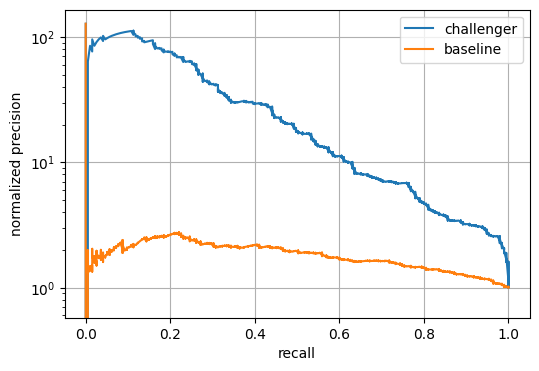

In [18]:
fig, ax = pp.subplots(figsize=(6, 4))

for model_name, model_obj in {
    'challenger': model_chal,
    'baseline': model_base
}.items():
    proba_arr = model_obj.predict_proba(test_X)[:,1]
    precision_arr, recall_arr, _ = sk_mx.precision_recall_curve(test_Y, proba_arr)
    #
    i_order = np.argsort(recall_arr)
    recall_arr = recall_arr[i_order]
    precision_arr = precision_arr[i_order]
    norm_precision_arr = precision_arr / np.mean(test_Y)
    
    ax.plot(recall_arr, norm_precision_arr, label=model_name)

ax.set_yscale('log')
ax.legend()
ax.set_ylabel('normalized precision')
ax.set_xlabel('recall')
ax.grid()

Store and load the default classifier

In [19]:
save_model_name = 'model_def.json'
model_chal.save_model(save_model_name, format='json')
model_chal = None
model_chal = cb.CatBoostClassifier().load_model(save_model_name, format='json')

Compute monthly loss with the classifier

In [20]:
investigative_capacity = np.round(test_ratio*0.3*400).astype(int)
bootstrap_run_count = 300

res_dict_list = []
#
for (cur_year, cur_month), sub_df in train_test_df.query(f'{is_test_name}==1').groupby(['txn_year', 'txn_month']):
    cur_X = sub_df[feature_col_list].values
    
    cur_proba = model_chal.predict_proba(cur_X)[:,1]
    sub_df = sub_df.assign(fraud_proba=cur_proba).sort_values('fraud_proba', ascending=False)

    cur_full_fraud_arr = (sub_df.is_fraud_flag * sub_df.transactionAmount).values
    cur_full_fraud = np.sum(cur_full_fraud_arr)
    cur_loss = np.sum(cur_full_fraud_arr[investigative_capacity:])

    ### bootstratp simulate randomly investigating a selection of transactions
    random_fraud_loss = 0.0

    for i_bootstrap_run in range(bootstrap_run_count):
        i_not_investigated = npr.choice(
            range(len(sub_df)),
            replace=False,
            size=len(sub_df)-investigative_capacity
        )
        ###
        random_fraud_loss += np.sum(cur_full_fraud_arr[i_not_investigated])
    #
    random_fraud_loss /= bootstrap_run_count 
    
    res_dict_list.append({
        'year_month': f'{cur_year}_{cur_month}',
        'fraud_proportion': np.mean(sub_df.is_fraud_flag),
        'loss': cur_loss,
        'random_fraud_loss': random_fraud_loss,
        'fraud': cur_full_fraud,
        'transacted_amount': sub_df.transactionAmount.sum()
    })

####


res_df = pd.DataFrame(res_dict_list)
reduction_in_loss = np.mean(1-(res_df.loss/res_df.random_fraud_loss))
print(f'Reduction in fraud loss compared to random sampling is {reduction_in_loss*100:.1f}%')

res_df

Reduction in fraud loss compared to random sampling is 32.1%


,year_month,fraud_proportion,loss,random_fraud_loss,fraud,transacted_amount
0,2017_1,0.002146,33.90,70.383733,71.18,98732.97
1,2017_2,0.003913,308.39,596.515533,613.39,104031.42
2,2017_3,0.009014,1209.68,1947.167367,1979.51,97114.44
3,2017_4,0.008242,633.33,748.947633,755.82,107970.17
4,2017_5,0.002004,529.97,552.697800,564.22,91357.76
5,2017_6,0.022331,2021.23,2897.671767,2964.03,112555.80
6,2017_7,0.008920,315.98,2300.013833,2353.02,102109.05
7,2017_8,0.006811,1115.15,1567.120567,1596.74,130935.56
8,2017_9,0.013684,10705.37,11204.522467,11382.74,117674.94
9,2017_10,0.016402,260.20,1712.084033,1754.60,101950.98


Recording various reductions in loss for different train-test splits:

```
37.9%, 51.5%, 36.7%, 55.5%, 44.3%, 34.9%, 24.1%, 45.2%, 38.5%, 37.1%
```

So expecting reduction in fraud loss in the range of $41\pm 8$%

Adjusting for targets to be upweighted by target rate and the transaction amount. Then the reduction in loss is:

```
39.2%, 41.4%, 44.7%, 41.8%, 51.8%, 43.5%, 38.9%, 48.9%, 50.3%, 35.1%
```

So $44\pm 5$%. Seems slightly higher reduction and slightly smaller variability